In [13]:
using Pkg

Pkg.activate("../Project.toml")

using Random
import .Iterators: cycle, Cycle, take

using JLD2
using CUDA
using Statistics
using Random

import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
using Plots; default(fmt=:png,ls=:auto)

import Knet
using Knet: deconv4, conv4, unpool, pool, mat, sigm, KnetArray, nll, zeroone, progress, adam!, sgd!, param, param0, dropout, relu, minibatch, Data
import Knet: train!
using Knet

 Activating environment at `~/yolo-julia/Project.toml`


In [15]:
include("../coco2014.jl")

od = load_data("../dataset/overfit_data.jld2");


┌ Info: Loaded: ../dataset/overfit_data.jld2.
└ @ Main /home/ec2-user/yolo-julia/coco2014.jl:43


In [16]:
dtrn = minibatch(od.x[:, :, :, 1:90], od.y[1:90], 8; xsize = (416,416,3,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(od.x[:, :, :, 90:end], od.y[90:end], 2; xsize = (416,416,3,:), xtype=Knet.atype());


In [17]:
include("../models.jl")

Random.seed!(1)
darknet = Darknet("../yolov3.cfg"; verbose=false);

xx, yy = first(dtrn)

# @diff a = darknet(xx, yy)

out = darknet(xx, training=false);

In [56]:
function train!(model, train_data::Data, test_data::Data;
                  period::Int=4, iters::Int=100, lr=0.15, optimizer=sgd!)  # or optimizer=adam!
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for i in 0:period:iters
        push!(train_loss, model(train_data))
        push!(test_loss, model(test_data))
        
        optimizer(model, take(cycle(train_data), period); lr=lr)
        
        
        println("Iter: ", i, " ", train_loss[end])
    end
    
    return 0:period:iters, train_loss, train_acc, test_loss, test_acc
end

train! (generic function with 2 methods)

In [57]:
iters, trnloss, trnacc, tstloss, tstacc = train!(
    darknet, dtrn, dtst; 
    period=1, iters=1000, lr=1e-3, optimizer=adam!);


Iter: 0 5.981439262289893
Iter: 1 5.990671356237408
Iter: 2 6.178711599435828
Iter: 3 6.011127591834151
Iter: 4 6.218804837792096
Iter: 5 6.225945172132078
Iter: 6 6.083525457637893
Iter: 7 6.244214511215687
Iter: 8 5.883099269716239
Iter: 9 6.066481797710399
Iter: 10 6.086215588453817


LoadError: InterruptException:

In [54]:
function save_model(model::Darknet, filename::String)
    FileIO.save(filename, "darknet59", model)
    @info "Saved to: $filename."
end

save_model(darknet, "../overfit_model_20201228.jld2")

┌ Info: Saved to: ../overfit_model_20201228.jld2.
└ @ Main In[54]:3


In [85]:
# include("../utils/train_utils.jl")

import IterTools: ncycle

function train!(model, train_data::Data, val_data::Data;
                period::Int=5, epoch::Int=10, lr=0.001, 
                optimizer=adam, filename::String=""
)
    
    bestloss = model(val_data)

    trn_loss = []
    trn_map = []
    val_loss = []
    val_map = []

    progress!(optimizer(model, ncycle(train_data, epoch), lr=lr), steps=period) do y
        push!(trn_loss, model(train_data))
        push!(val_loss, model(val_data))
        
        if dev_loss[end] < bestloss
            bestloss = val_loss[end];
            
            if filename != ""
                save_model(model, filename)
            end
        end
    end

    return trn_loss, trn_map, val_loss, val_map
end
trn_loss, val_loss = train!(model, dtrn, dtst, epoch=1, period=3);

# model = Darknet("../yolov3.cfg"; verbose=false);

# import ProgressMeter

# function train!(model, train_data::Data, val_data::Data;
#                   period::Int=1, epoch::Int=10, lr=0.001, optimizer=adam!)  # or optimizer=adam!
    
#     train_loss = []
#     val_loss = []
#     train_acc = []
#     val_acc = []
#     push!(train_loss, model(train_data))
#     push!(val_loss, model(val_data))
    
#     p = ProgressMeter.Progress(length(files), 1)
    
#     for ep in 1:epoch
#         for i in 1:period:length(train_data)
        
#             optimizer(model, take(cycle(train_data), period); lr=lr)
    
#             push!(train_loss, model(train_data))
#             push!(val_loss, model(val_data))
            
#             println("epoch: $ep, iter: $i, trnloss: ", train_loss[end], " valloss: ", val_loss[end])
#         end
#     end
    
#     return train_loss, train_acc, val_loss, val_acc
# end

# train_loss, train_acc, test_loss, test_acc = train!(model, dtrn, dtst, epoch=1)

┣███████████████████▉┫ [100.00%, 11/11, 01:21/01:21, 7.38s/i] nothing


(Any[556.9380690869216, 557.012970072505, 594.3973641472105, 627.2980522930688, 625.7982503097165], Any[], Any[604.5196439443976, 601.180484015748, 631.4131504271031, 662.3526672969758, 658.5452983911931], Any[])

In [81]:
model(xx, training=false)

85×10647×8 KnetArray{Float32,3}:
[:, :, 1] =
  49.083       48.5747      48.4412     …  420.424      419.905
  47.8711      80.2338     112.188         411.275      419.5
 102.914      101.294      100.536          60.2623      52.7654
 104.949      107.76       109.538          28.7568      26.0535
   0.0282741    0.0340673    0.0380523       0.0235072    0.0311073
   0.767258     0.836992     0.849285   …    0.52765      0.586507
   0.187381     0.183115     0.185748        0.223507     0.170546
   0.316257     0.282782     0.274937        0.314552     0.294524
   0.194681     0.216427     0.225467        0.0778995    0.126955
   0.480867     0.485209     0.475096        0.187209     0.255996
   0.0293299    0.0305936    0.0340243  …    0.134199     0.170312
   0.247979     0.259168     0.270646        0.113426     0.123959
   0.360118     0.404021     0.415325        0.304606     0.342403
   ⋮                                    ⋱    ⋮          
   0.145231     0.138529     0.141117 

In [68]:
model(xx, training=false)

85×10647×8 KnetArray{Float32,3}:
[:, :, 1] =
  50.8215      50.5208      50.3048     …  420.271      419.935
  47.5046      79.6771     111.566         411.743      419.739
  88.1401      92.915       94.709          50.279       42.0508
 124.31       130.731      132.182          20.711       18.6054
   0.042013     0.0485536    0.0567615       0.0510666    0.0707914
   0.761411     0.858422     0.875161   …    0.441216     0.510805
   0.237067     0.219143     0.222377        0.276381     0.235933
   0.388399     0.349325     0.334952        0.322944     0.338352
   0.274598     0.297829     0.310763        0.143203     0.202159
   0.430627     0.422661     0.415505        0.21506      0.259124
   0.0493929    0.0476594    0.0537201  …    0.218228     0.271331
   0.3238       0.324568     0.337229        0.210977     0.255401
   0.422429     0.466977     0.479138        0.350103     0.37933
   ⋮                                    ⋱    ⋮          
   0.203171     0.186821     0.189952

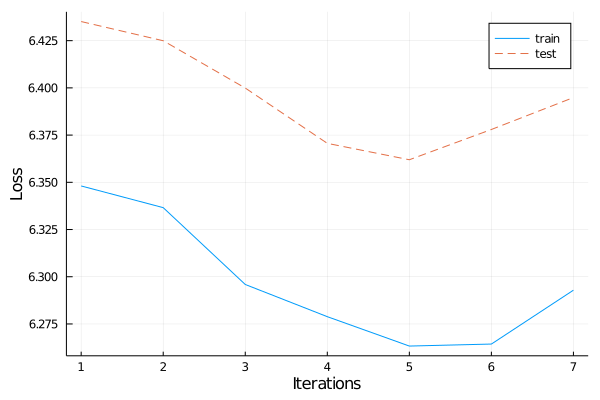

In [82]:
plot(1:length(val_loss), log.(trn_loss), label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(1:length(val_loss), log.(val_loss), label="test"))

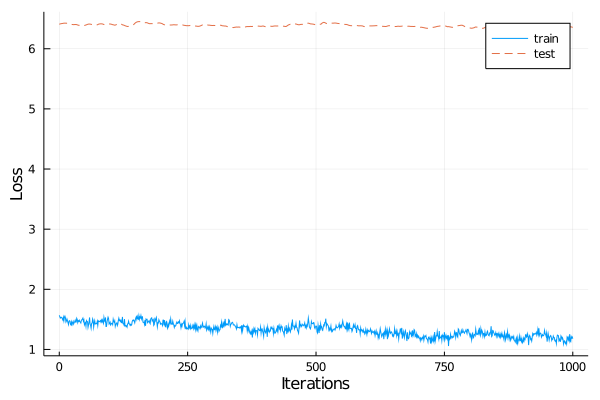

In [40]:
plot(iters, log.(trnloss), label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(iters, log.(tstloss), label="test"))

In [45]:
ooo = res(darknet, xx)

85×10647×8 KnetArray{Float32,3}:
[:, :, 1] =
  50.3176        87.3048       120.186        …  412.994       420.882
  50.5413        52.6785        55.5135          419.237       419.843
  61.8813        55.292         62.7315           38.0672       28.5486
 184.384        156.996        214.872            26.6272       28.4635
   1.706f-5       2.90988f-6     3.0914f-5         4.09002f-5    1.74146f-5
   0.995959       0.972642       0.999839     …    0.601352      0.423357
   0.000360693    0.000253771    0.0100279         0.00993899    0.012906
   0.0148731      0.301634       0.0263191         0.30451       0.623209
   2.93189f-5     0.00153125     0.0106978         0.0216935     0.00947922
   9.99444f-5     0.408973       0.0084567         0.0859258     0.32596
   2.84323f-5     3.01739f-5     0.000308092  …    0.010762      0.0141109
   0.00957448     0.0483081      0.0086093         0.0100339     0.0128397
   0.00799758     0.0120012      0.0256323         0.176322      0.09900

In [53]:
sum(ooo[5, :, 1] .> 0.8)

27.0f0

In [42]:
function res(c, xx)
    yolo_out = c(xx)
    results = nothing

    for (i, out) in enumerate(yolo_out)
        layer_id = c.yolo_layers[i]

        no, ny, nx, na, bs = size(out)

        yv, xv = meshgrid(1:ny, 1:nx)
        grid = cat(yv, xv, dims=3)
        grid = permutedims(grid, (3, 1, 2))
        grid = reshape(grid, (2, ny, nx, 1, 1))
        grid = convert(c.atype, grid)

        io = deepcopy(out)
        io[1:2,:,:,:,:] = sigm.(io[1:2,:,:,:,:]) .+ grid
        io[3:4,:,:,:,:] = exp.(io[3:4,:,:,:,:]) .* c.module_list[layer_id].anchor_wh
        io[1:4,:,:,:,:] = io[1:4,:,:,:,:] .* c.module_list[layer_id].stride
        io[5:end,:,:,:,:] = sigm.(io[5:end,:,:,:,:])

        r = reshape(io, (no, :, bs))

        if results == nothing
            results = r
        else
            results = cat(results, r, dims=2)
        end
    end

    return results
end

res (generic function with 1 method)

In [38]:
maximum(sigm.(out[5, :, :]))

0.7310422f0